In [26]:
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from collections import Counter
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import math
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


In [32]:
#mscaled_dataset_with_fuel_leak_supervised_moreLeakage.csv
df = pd.read_csv(
    '/Users/adaiagrundland/Documents/GitHub/Scott/Capstone/generated_data/scaled_dataset_with_fuel_leak_supervised_moreLeakage.csv'
)


In [66]:
def analyze_and_replace(df, col):
    for i in range(1, len(df) - 1):
        if df.loc[i - 1,
                  col] == df.loc[i + 1,
                                 col] and df.loc[i, col] != df.loc[i - 1, col]:
            df.loc[i, col] = df.loc[i - 1, col]
    output= df[col]
    
    return output


In [35]:
#new column Label with only 0 and 1
df["Label"] = np.where(df['leakage'] == 0, 0, 1)

# Visualization of Anomalies

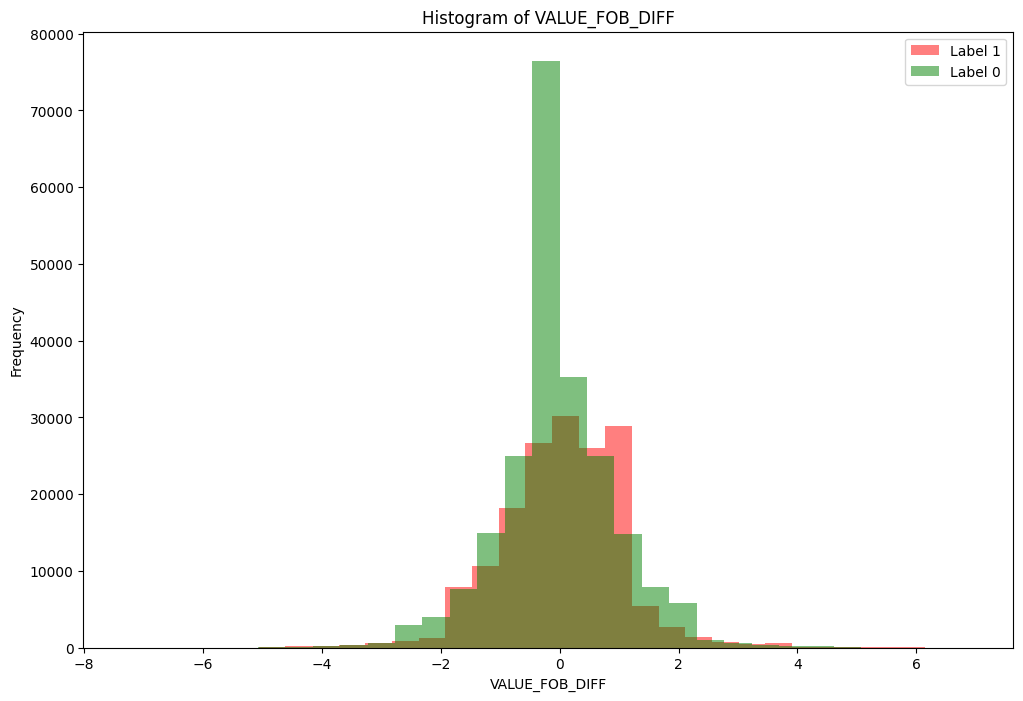

In [36]:
# Selecting the data for the histogram
data_1 = df[df['Label']==1]['VALUE_FOB_DIFF']
data_0 = df[df['Label']==0]['VALUE_FOB_DIFF']

# Plotting the histograms
plt.figure(figsize=(12, 8))
plt.hist(data_1, bins=30, alpha=0.5, color='red', label='Label 1')
plt.hist(data_0, bins=30, alpha=0.5, color='green', label='Label 0')
plt.title('Histogram of VALUE_FOB_DIFF')
plt.xlabel('VALUE_FOB_DIFF')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()


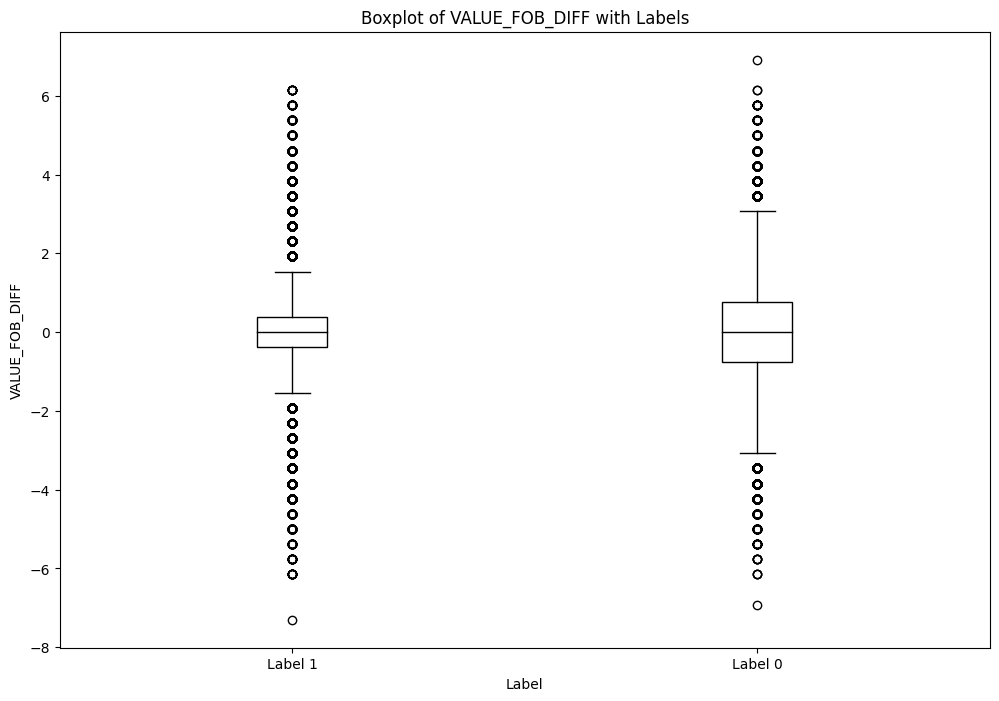

In [38]:
# Selecting the data for the boxplot
data_1 = df[df['leakage'] == 1]['VALUE_FOB_DIFF']
data_0 = df[df['leakage'] == 0]['VALUE_FOB_DIFF']

# Creating a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Creating a boxplot with colored data points
boxprops = dict(facecolor='white', color='black')
whiskerprops = dict(color='black')
flierprops = dict(marker='o', markerfacecolor='none', markersize=6)
medianprops = dict(color='black')
capprops = dict(color='black')

ax.boxplot([data_1, data_0],
           labels=['Label 1', 'Label 0'],
           patch_artist=True,
           boxprops=boxprops,
           whiskerprops=whiskerprops,
           flierprops=flierprops,
           medianprops=medianprops,
           capprops=capprops)

# Setting the box colors
box_colors = ['red', 'green']
for patch, color in zip(ax.artists, box_colors):
    patch.set_facecolor(color)

# Setting the title and labels
ax.set_title('Boxplot of VALUE_FOB_DIFF with Labels')
ax.set_xlabel('Label')
ax.set_ylabel('VALUE_FOB_DIFF')

# Displaying the plot
plt.show()


# Z-Statistic algorithm 

In [39]:
#new dataframe with only required columns
dfx = df[["VALUE_FOB_DIFF", "leakage"]]
dfx.sample(10)


,VALUE_FOB_DIFF,leakage
216952,-1.921340,0
60934,0.000008,0
201188,-0.768531,0
330139,-0.384262,1
18765,-0.768531,0
29748,-1.152801,0
11701,0.384277,0
58513,1.537086,0
218563,1.537086,0
179500,0.768547,0


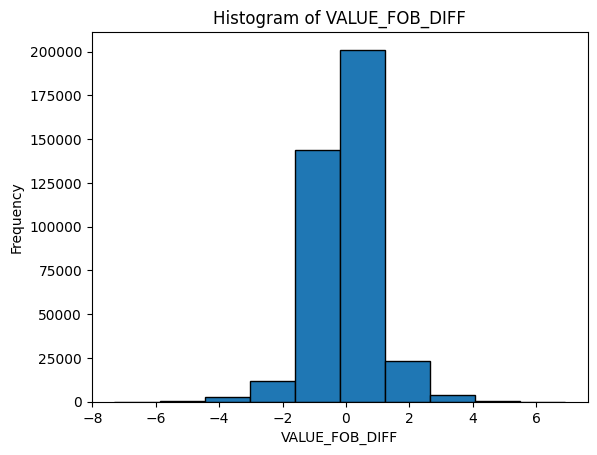

In [40]:
#Check for normality 
dfx['VALUE_FOB_DIFF'].plot(kind='hist', edgecolor='black')
plt.title('Histogram of VALUE_FOB_DIFF')
plt.xlabel('VALUE_FOB_DIFF')
plt.show()


In [41]:
#new column Label with only 0 and 1
dfx["Label"] = np.where(dfx['leakage'] == 0, 0, 1)

/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_74865/1684253527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx["Label"] = np.where(dfx['leakage'] == 0, 0, 1)


#### with replacement of 0 and 1s

In [72]:
#Z statistic
X_train, X_test, y_train, y_test = train_test_split(dfx['VALUE_FOB_DIFF'],
                                                    dfx['Label'],
                                                    test_size=0.2,
                                                    random_state=42)

#  Calculate the z-scores for the training set
mean = X_train.mean()
std = X_train.std()
X_train['z_score'] = np.abs((X_train - mean) / std)

# Determine the threshold for the z-value
threshold = 0.8 # Set the threshold value for the z-score

# Classify anomalies for the training set based on the threshold
X_train['anomaly'] = np.where(X_train['z_score'] > threshold, 1, 0)


# Evaluate the performance of the algorithm on the training set
y_train_pred = X_train['anomaly']
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print("Performance on the training set:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 Score:", f1_train)

# Apply the algorithm to the test set
X_test['z_score'] = np.abs((X_test- mean) / std)
X_test['anomaly'] = np.where(X_test['z_score'] > threshold, 1, 0)
dataframe_anom= pd.DataFrame({'anomalies': X_test['anomaly']})
X_test['anomaly']= analyze_and_replace(dataframe_anom, 'anomalies')

#  Evaluate the performance on the test set
y_test_pred = X_test['anomaly']
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

print("\nPerformance on the test set:")

print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)


Performance on the training set:
Accuracy: 0.5314776694393
Precision: 0.41783004998529844
Recall: 0.270699035340374
F1 Score: 0.3285444112030259

Performance on the test set:
Accuracy: 0.5513783490785195
Precision: 0.41688099134907647
Recall: 0.16393894814269952
F1 Score: 0.23533293737213754


In [73]:
# Initialize the best threshold and the best score
best_threshold = None
best_score = -np.inf

# Iterate over a range of possible threshold values
for threshold in np.linspace(start=0, stop=5, num=100):
    print( threshold)
    # Classify anomalies for the training set based on the threshold
    X_train['anomaly'] = np.where(X_train['z_score'] > threshold, 1, 0)
    y_train_pred = X_train['anomaly']


    # Calculate the score
    score = f1_score(y_train, y_train_pred)
    print(score)
    print()

    # If this threshold gives a better score, update the best threshold and the best score
    if score > best_score:
        best_threshold = threshold
        best_score = score

print('Best threshold:', best_threshold)
print('Best F1 Score:', best_score)


0.0
0.5949516288431723

0.050505050505050504
0.5570094527893925

0.10101010101010101
0.5570094527893925

0.15151515151515152
0.5570094527893925

0.20202020202020202
0.5570094527893925

0.25252525252525254
0.5570094527893925

0.30303030303030304
0.5570094527893925

0.35353535353535354
0.5570094527893925

0.40404040404040403
0.45409352835327643

0.45454545454545453
0.45409352835327643

0.5050505050505051
0.45409352835327643

0.5555555555555556
0.45409352835327643

0.6060606060606061
0.45409352835327643

0.6565656565656566
0.45409352835327643

0.7070707070707071
0.45409352835327643

0.7575757575757576
0.45409352835327643

0.8080808080808081
0.3285444112030259

0.8585858585858586
0.3285444112030259

0.9090909090909091
0.3285444112030259

0.9595959595959596
0.3285444112030259

1.0101010101010102
0.3285444112030259

1.0606060606060606
0.3285444112030259

1.1111111111111112
0.3285444112030259

1.1616161616161615
0.21145058175975204

1.2121212121212122
0.21145058175975204

1.2626262626262625
0

### Hypothesis Why Z-score does not work

In [18]:
#merged_dataset_with_fuel_leak_supervised_moreLeakage.csv
df_not_scaled = pd.read_csv(
    '/Users/adaiagrundland/Documents/GitHub/Scott/Capstone/generated_data/merged_dataset_with_fuel_leak_supervised_moreLeakage.csv'
)


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_74865/3480879750.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_not_scaled = pd.read_csv(


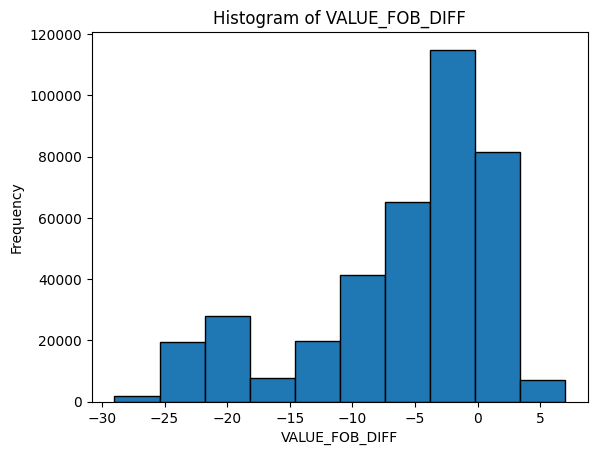

In [19]:
#Check distribution
df_not_scaled['VALUE_FOB_DIFF'].plot(kind='hist', edgecolor='black')
plt.title('Histogram of VALUE_FOB_DIFF')
plt.xlabel('VALUE_FOB_DIFF')
plt.show()


# Supervised Algorithm 

In [20]:
# Define the models
models = [
    XGBClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    DecisionTreeClassifier(),
    LogisticRegression(max_iter=1000)
]

model_names = [
    "XGBClassifier", "RandomForestClassifier", "AdaBoostClassifier",
    "GradientBoostingClassifier", "DecisionTreeClassifier",
    "LogisticRegression"
]

# Select features and target
features = df.select_dtypes(include=[np.number]).drop(
    columns=['Label', 'leakage'])
target = df['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

# Prepare an empty DataFrame to store the results
results = pd.DataFrame(
    columns=['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Iterate over models, train, make predictions and get classification metrics
for model, name in zip(models, model_names):
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report["accuracy"]
    precision = report["macro avg"]["precision"]
    recall = report["macro avg"]["recall"]
    f1 = report["macro avg"]["f1-score"]

    results = results.append(
        {
            "Model": name,
            "AUC": auc,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        },
        ignore_index=True)

# Display the results
results


Training XGBClassifier...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_74865/441989080.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


Training RandomForestClassifier...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_74865/441989080.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


Training AdaBoostClassifier...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_74865/441989080.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


Training GradientBoostingClassifier...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_74865/441989080.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


Training DecisionTreeClassifier...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_74865/441989080.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


Training LogisticRegression...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_74865/441989080.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


,Model,AUC,Accuracy,Precision,Recall,F1 Score
0,XGBClassifier,0.999902,0.996954,0.996947,0.996805,0.996876
1,RandomForestClassifier,0.999699,0.996231,0.996319,0.995951,0.996134
2,AdaBoostClassifier,0.999806,0.995302,0.995286,0.995078,0.995181
3,GradientBoostingClassifier,0.999836,0.995535,0.995570,0.995270,0.995419
4,DecisionTreeClassifier,0.994334,0.994450,0.994284,0.994334,0.994309
5,LogisticRegression,0.497379,0.578894,0.289451,0.499989,0.366645


In [21]:
test_data = pd.concat([X_test, y_test], axis=1)

In [22]:
test_data_0 = test_data[test_data['Label'] == 0]
test_data_1 = test_data[test_data['Label'] == 1]

# Randomly sample from each dataframe
test_data_0 = test_data_0.sample(n=40000, random_state=1)
test_data_1 = test_data_1.sample(n=10000, random_state=1)

# Concatenate the two samples to get your final sample
df_sample_test = pd.concat([test_data_0, test_data_1])

In [23]:
df_sample_test.Label.value_counts()

0    40000
1    10000
Name: Label, dtype: int64

In [24]:
X_df_sample_test = df_sample_test.drop('Label', axis=1)
y_df_sample_test = df_sample_test['Label']

In [25]:
#############NEW TEST

# Prepare an empty DataFrame to store the results
results = pd.DataFrame(
    columns=['Model','AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Iterate over models, train, make predictions and get classification metrics
for model, name in zip(models, model_names):
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_df_sample_test)
    y_pred_proba = model.predict_proba(X_df_sample_test)[:, 1]

    auc = roc_auc_score(y_df_sample_test, y_pred_proba)
    report = classification_report(y_df_sample_test, y_pred, output_dict=True)
    accuracy = report["accuracy"]
    precision = report["macro avg"]["precision"]
    recall = report["macro avg"]["recall"]
    f1 = report["macro avg"]["f1-score"]

    results = results.append(
        {
            "Model": name,
            "AUC": auc,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        },
        ignore_index=True)

# Display the results
results

Training XGBClassifier...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_74865/97659079.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


Training RandomForestClassifier...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_74865/97659079.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


Training AdaBoostClassifier...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_74865/97659079.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


Training GradientBoostingClassifier...


KeyboardInterrupt: 

In [26]:
#crossvalidated Test

# Prepare an empty DataFrame to store the results
results = pd.DataFrame(columns=[
    'Model', 'CV Mean AUC', 'CV Std AUC', 'Accuracy', 'Precision', 'Recall',
    'F1 Score'
])

# Iterate over models, train, make predictions and get classification metrics
for model, name in zip(models, model_names):
    print(f"Training and performing cross-validation on {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Perform cross-validation and get AUC scores
    cv_auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report["accuracy"]
    precision = report["macro avg"]["precision"]
    recall = report["macro avg"]["recall"]
    f1 = report["macro avg"]["f1-score"]

    results = results.append(
        {
            "Model": name,
            "CV Mean AUC": cv_auc.mean(),
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        },
        ignore_index=True)

# Display the results
results



Training and performing cross-validation on XGBClassifier...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_73589/893018627.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


Training and performing cross-validation on RandomForestClassifier...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_73589/893018627.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


Training and performing cross-validation on AdaBoostClassifier...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_73589/893018627.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


Training and performing cross-validation on GradientBoostingClassifier...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_73589/893018627.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


Training and performing cross-validation on DecisionTreeClassifier...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_73589/893018627.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


Training and performing cross-validation on LogisticRegression...


/Users/adaiagrundland/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adaiagrundland/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adaiagrundland/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

,Model,CV Mean AUC,CV Std AUC,Accuracy,Precision,Recall,F1 Score
0,XGBClassifier,0.951184,NaN,0.883738,0.893672,0.870775,0.877946
1,RandomForestClassifier,0.943295,NaN,0.880601,0.891117,0.867145,0.874498
2,AdaBoostClassifier,0.919051,NaN,0.859843,0.870745,0.844754,0.852172
3,GradientBoostingClassifier,0.933162,NaN,0.869409,0.886678,0.852282,0.861264
4,DecisionTreeClassifier,0.822131,NaN,0.822276,0.817774,0.819338,0.818496
5,LogisticRegression,0.482604,NaN,0.576327,0.288163,0.500000,0.365614


In [27]:
# Define the parameter grids for each model
# For Random Forest
rf_param_grid = {
    'n_estimators': [100],  # lower number of trees
    'max_depth': [5],  # lower depth
    'min_samples_split': [2, 5, 10]  # not affecting speed that much
}

# For XGBoost
xgb_param_grid = {
    'n_estimators': [100],  # lower number of gradient boosted trees
    'max_depth': [3],  # lower depth
    'learning_rate': [0.1,0.01,0.001]  # higher learning rate, but still reasonable to avoid underfitting
}


# Create the models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)

# Perform grid search for each model
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='roc_auc')
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='roc_auc')

# Train and perform cross-validation with grid search for Random Forest
print("Training and performing cross-validation on Random Forest...")
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_
rf_cv_auc = rf_grid_search.best_score_

# Train and perform cross-validation with grid search for XGBoost
print("Training and performing cross-validation on XGBoost...")
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_
xgb_cv_auc = xgb_grid_search.best_score_

# Evaluate the best models on the test set
rf_best_model.fit(X_train, y_train)
rf_y_pred = rf_best_model.predict(X_test)
rf_y_pred_proba = rf_best_model.predict_proba(X_test)[:, 1]

xgb_best_model.fit(X_train, y_train)
xgb_y_pred = xgb_best_model.predict(X_test)
xgb_y_pred_proba = xgb_best_model.predict_proba(X_test)[:, 1]

# Calculate classification metrics for the best models
rf_report = classification_report(y_test, rf_y_pred, output_dict=True)
rf_accuracy = rf_report["accuracy"]
rf_precision = rf_report["macro avg"]["precision"]
rf_recall = rf_report["macro avg"]["recall"]
rf_f1 = rf_report["macro avg"]["f1-score"]

xgb_report = classification_report(y_test, xgb_y_pred, output_dict=True)
xgb_accuracy = xgb_report["accuracy"]
xgb_precision = xgb_report["macro avg"]["precision"]
xgb_recall = xgb_report["macro avg"]["recall"]
xgb_f1 = xgb_report["macro avg"]["f1-score"]

# Append the results to the DataFrame
results = results.append(
    {
        "Model": "Random Forest (Grid Search)",
        "AUC": rf_cv_auc,
        "Accuracy": rf_accuracy,
        "Precision": rf_precision,
        "Recall": rf_recall,
        "F1 Score": rf_f1
    },
    ignore_index=True)

results = results.append(
    {
        "Model": "XGBoost (Grid Search)",
        "AUC": xgb_cv_auc,
        "Accuracy": xgb_accuracy,
        "Precision": xgb_precision,
        "Recall": xgb_recall,
        "F1 Score": xgb_f1
    },
    ignore_index= True)


Training and performing cross-validation on Random Forest...
Training and performing cross-validation on XGBoost...


/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_73589/1527651870.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
/var/folders/tg/t_qy0qkn3xq9ysqrk97gyy5r0000gq/T/ipykernel_73589/1527651870.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


In [28]:
results

,Model,CV Mean AUC,CV Std AUC,Accuracy,Precision,Recall,F1 Score,AUC
0,XGBClassifier,0.951184,NaN,0.883738,0.893672,0.870775,0.877946,NaN
1,RandomForestClassifier,0.943295,NaN,0.880601,0.891117,0.867145,0.874498,NaN
2,AdaBoostClassifier,0.919051,NaN,0.859843,0.870745,0.844754,0.852172,NaN
3,GradientBoostingClassifier,0.933162,NaN,0.869409,0.886678,0.852282,0.861264,NaN
4,DecisionTreeClassifier,0.822131,NaN,0.822276,0.817774,0.819338,0.818496,NaN
5,LogisticRegression,0.482604,NaN,0.576327,0.288163,0.500000,0.365614,NaN
6,Random Forest (Grid Search),NaN,NaN,0.795438,0.830857,0.766361,0.774081,0.868948
7,XGBoost (Grid Search),NaN,NaN,0.868983,0.887677,0.851287,0.860553,0.932633
